<a href="https://colab.research.google.com/github/Lit-IFRN/PreverChuvaSemPegadinha/blob/main/Prever_Chuva_sem_pegadinha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [105]:
data = pd.read_csv('data.csv', date_parser = True)
data = data.filter(['DT_MEDICAO', 'CHUVA'], axis=1)

data_test = data[data['DT_MEDICAO']>='2018-01-01'].copy()
data_training = data[data['DT_MEDICAO']<'2020-01-01'].copy()

data_test = data_test.drop(['DT_MEDICAO'], axis = 1)
data_training = data_training.drop(['DT_MEDICAO'], axis = 1)

In [106]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)


In [107]:
n_input = 365
batch_size = 128
generator = TimeseriesGenerator(data_training, data_training, length=n_input, batch_size=batch_size)

In [108]:
regressor = Sequential()

regressor.add(LSTM(units = n_input, activation = 'relu', return_sequences = True, input_shape = (n_input, 1)))
regressor.add(LSTM(units = int(n_input/2), activation = 'relu', return_sequences = True))
regressor.add(LSTM(units = n_input, activation = 'relu', return_sequences = False))

regressor.add(Dense(units = 1))


In [109]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor.fit(generator, epochs=1)


35/35 [==============================] - 411s 12s/step - loss: 0.0039 - accuracy: 0.5330


In [110]:
scaled_data_test = scaler.transform(data_test)

In [111]:
test_generator = TimeseriesGenerator(scaled_data_test, scaled_data_test, batch_size=batch_size, length=n_input)                            
y_test = test_generator.targets[n_input:]

y_pred = regressor.predict(test_generator)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)


In [112]:
y_test

array([[  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [ 22.8],
       [  0. ],
       [  0.4],
       [  0. ],
       [  6.4],
       [  0. ],
       [  1.2],
       [  3.4],
       [  0.2],
       [ 24.4],
       [  3.2],
       [  0.2],
       [  1.2],
       [  3.2],
       [  0. ],
       [  0. ],
       [  0. ],
       [  2.2],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0.2],
       [  0. ],
       [  0. ],
       [  0. ],
       [  0.2],
       [  0. ],
       [  3. ],
       [  0. ],
       [ 11.2],
       [ 32.8],
       [  0. ],
       [  2.8],
       [  0. ],
       [  1. ],
       [  0. ],
       [ 17.2],
       [ 12. ],
       [

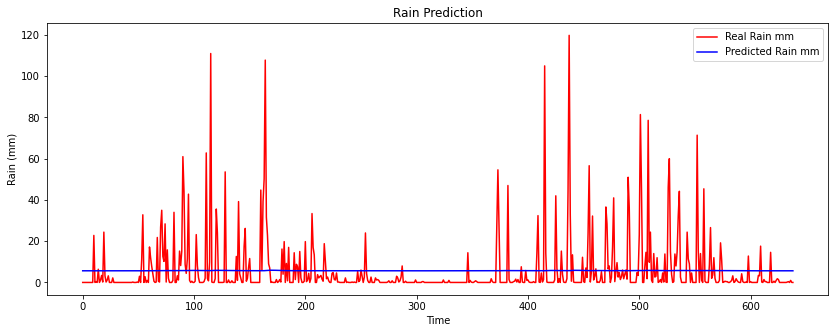

In [113]:
plt.figure(figsize=(14,5))
plt.plot()
plt.plot(y_test, color = 'red', label = 'Real Rain mm')
plt.plot(y_pred, color = 'blue', label = 'Predicted Rain mm')

plt.title('Rain Prediction')
plt.xlabel('Time')
plt.ylabel('Rain (mm)')
plt.legend()
plt.show()

In [ ]:
# Get last 182 days to predict tomorrow
necessaryDataToPredict = data.tail(182).drop("DT_MEDICAO", axis=1)

# Scale the last 182 days to between 0 and 1
scaledNecessaryDataToPredict = scaler.transform(necessaryDataToPredict)

# Convert the last 182 days to numpy array
npArrayScaledNecessaryDataToPredict = np.array([scaledNecessaryDataToPredict])

# Predict value
predicts = regressor.predict(npArrayScaledNecessaryDataToPredict)

# Revert predict scale (it was between 0 and 1 and now is the real value)

predictedValues = []

for i in range(0, 365):
  alo = np.append(npArrayScaledNecessaryDataToPredict[0], predicts, axis=0)
  alo = np.delete(alo, 0, axis=0)
  npArrayScaledNecessaryDataToPredict[0] = alo
  npArrayScaledNecessaryDataToPredict

  predicts = regressor.predict(npArrayScaledNecessaryDataToPredict)
  predictedValues.append(predicts[0])

predictedValues = np.array(predictedValues)
predictedValues *= scaler.inverse_transform(predictedValues)
predictedValues

plt.figure(figsize=(14,5))
plt.plot(predictedValues, color = 'red', label = 'Predicted Rain 2021')
plt.title('Predicted Rain 2021')
plt.xlabel('Time')
plt.ylabel('Rain (mm)')
plt.legend()
plt.show()